In [1]:
import numpy as np
import pandas as pd
import copy
import math
import time
import random
import operator
import datetime
import csv
from dataclasses import dataclass

from os import listdir
from os.path import isfile, join

import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.cm as cmx

# Utils

In [2]:
def read_instance_data(instances_dir: str, file_path: str) -> (np.array, np.array, np.array):
    with open(instances_dir + file_path, 'r') as f:
        lines = f.readlines()
        n_machines, n_parts = map(int, lines[0].split())
        matrix = np.zeros(shape=(n_machines, n_parts), dtype=int)
        for line in lines[1:]:
            values = list(map(int, line.split()))
            m_id = values[0]
            for i in values[1:]:
                #substract 1 is required if ids of machines start from 1
                matrix[m_id-1][i-1] = 1
    m_ids, p_ids = np.arange(1, n_machines+1), np.arange(1, n_parts+1)
    return matrix, m_ids, p_ids

In [3]:
def draw_matrix(matrix: np.array, m_ids: np.array=None, p_ids: np.array=None) -> None:
    n_machines, n_parts = matrix.shape
    fig, ax = plt.subplots(figsize=(n_machines, 7))
    ax.matshow(matrix, cmap='gray_r')
    ax.set_xticks(range(n_parts))
    ax.set_yticks(range(n_machines))
    if p_ids is not None:
        ax.set_xticklabels(p_ids)
    if m_ids is not None:
        ax.set_yticklabels(m_ids)
    plt.show()

In [4]:
instances_dir = './resources/instances/'
instances = [f for f in listdir(instances_dir) 
             if isfile(join(instances_dir, f)) 
             and (f.endswith(".txt"))]

05x07.txt


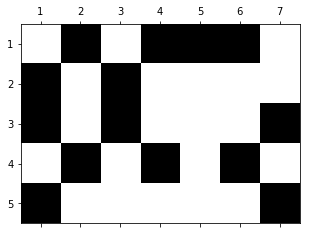

**************************************************
20x20.txt


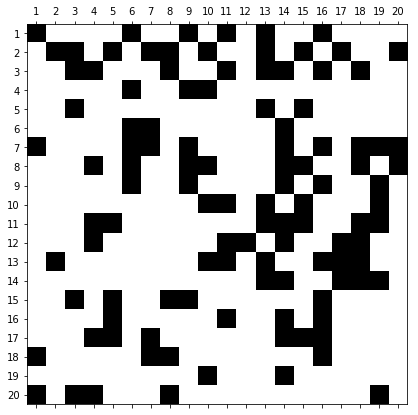

**************************************************
24x40.txt


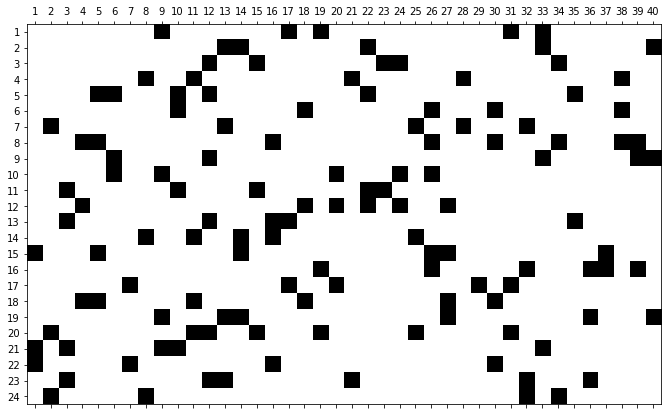

**************************************************
30x50.txt


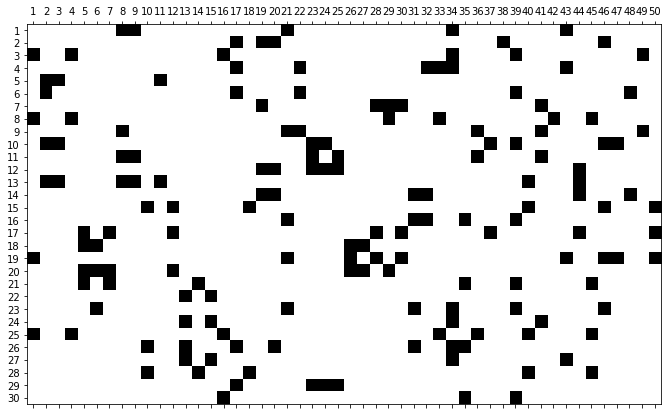

**************************************************
30x90.txt


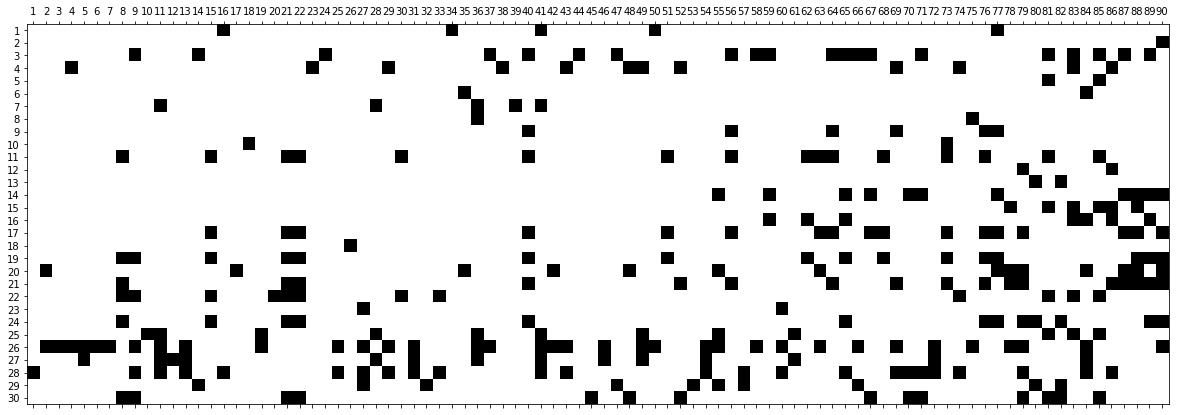

**************************************************
37x53.txt


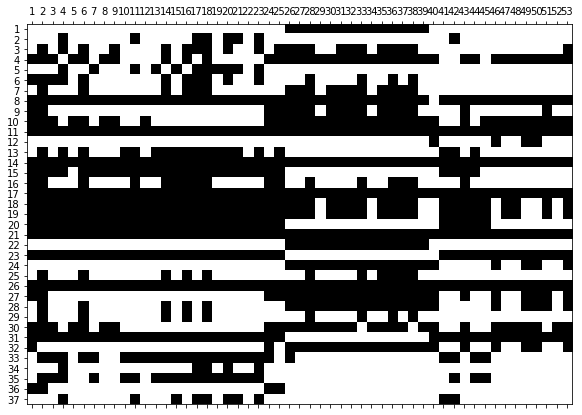

**************************************************


In [5]:
for instance in instances:
    matrix, m_ids, p_ids = read_instance_data(instances_dir, instance)
    print(instance)
    draw_matrix(matrix, m_ids, p_ids)
    print('*' * 50)

In [6]:
# def swap_columns(matrix: np.array, i: int, j: int, p_ids: np.array) -> (np.array, np.array):
#     new_matrix = matrix.copy()
#     new_matrix[:, i], new_matrix[:, j] = new_matrix[:, j], new_matrix[:, i].copy()
#     new_p_ids = p_ids.copy()
#     new_p_ids[i], new_p_ids[j] = new_p_ids[j], new_p_ids[i]
#     return new_matrix, new_p_ids

# def swap_rows(matrix: np.array, i: int, j: int, m_ids: np.array) -> (np.array, np.array):
#     new_matrix = matrix.copy()
#     new_matrix[i, :], new_matrix[j, :] = new_matrix[j, :], new_matrix[i, :].copy()
#     new_m_ids = m_ids.copy()
#     new_m_ids[i], new_m_ids[j] = new_m_ids[j], new_m_ids[i]
#     return new_matrix, new_m_ids

In [7]:
@dataclass
class Cluster():
    machines: np.array
    parts: np.array
    
    def __post_init__(self) -> None:
        self.n_machines = self.machines.size
        self.n_parts = self.parts.size

In [8]:
def obj_func(matrix: np.array, clusters: list) -> float:
    n_ones_total = (matrix == 1).sum()
    n_ones_in, n_zeros_in = 0, 0
    
    for cluster in clusters:
        for m_id in cluster.machines:
            for p_id in cluster.parts:
                if matrix[m_id-1][p_id-1] == 1:
                    n_ones_in += 1
                else:
                    n_zeros_in += 1
                    
    return n_ones_in / (n_ones_total + n_zeros_in)

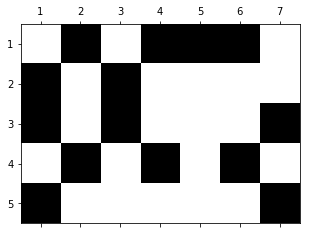

In [9]:
matrix, m_ids, p_ids = read_instance_data(instances_dir, '05x07.txt')
draw_matrix(matrix, m_ids, p_ids)

In [10]:
init_cluster = Cluster(m_ids, p_ids)
init_cluster

Cluster(machines=array([1, 2, 3, 4, 5]), parts=array([1, 2, 3, 4, 5, 6, 7]))

In [11]:
obj_func(matrix, [init_cluster])

0.4

In [12]:
two_clusters = [Cluster(m_ids[[0, 3]], p_ids[[1, 3, 4, 5]]), Cluster(m_ids[[1, 2, 4]], p_ids[[0, 2, 6]])]
two_clusters

[Cluster(machines=array([1, 4]), parts=array([2, 4, 5, 6])),
 Cluster(machines=array([2, 3, 5]), parts=array([1, 3, 7]))]

In [13]:
obj_func(matrix, two_clusters)

0.8235294117647058

In [14]:
three_clusters = [Cluster(m_ids[[0, 3]], p_ids[[1, 3, 4, 5]]), 
                  Cluster(m_ids[[1, 2]], p_ids[[0, 2]]),
                  Cluster(m_ids[[4]], p_ids[[6]])]
three_clusters

[Cluster(machines=array([1, 4]), parts=array([2, 4, 5, 6])),
 Cluster(machines=array([2, 3]), parts=array([1, 3])),
 Cluster(machines=array([5]), parts=array([7]))]

In [15]:
obj_func(matrix, three_clusters)

0.8